In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[4]').appName('taxi-analysis').getOrCreate()

23/11/09 23:18:53 WARN Utils: Your hostname, dori-ui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 192.168.123.103 instead (on interface en0)
23/11/09 23:18:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 23:18:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
import glob 
file_paths = '/Users/hangdori/_PML/fc_spark/data/trips/yellow*.csv' 
zone_paths = '/Users/hangdori/_PML/fc_spark/data/taxi+_zone_lookup.csv'

In [14]:
trips_df = spark.read.csv(f"file:///{file_paths}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{zone_paths}", inferSchema=True, header=True)

In [17]:
trips_df.createOrReplaceTempView('trips')
zone_df.createOrReplaceTempView('zone')

In [20]:
trips_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [39]:
comb_df = spark.sql(
    '''
    SELECT
        t.VendorID as vendor_id,
        TO_DATE(t.tpep_pickup_datetime) as pickup_date,
        HOUR(t.tpep_pickup_datetime) as pickup_time,
        t.tpep_pickup_datetime as pickup_datetime,
        pz.Zone Pickup_zone,
        t.tpep_dropoff_datetime as dropoff_datetime,
        TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
        HOUR(t.tpep_dropoff_datetime) as dropoff_time,
        dz.Zone Drop_zone,
        t.trip_distance,
        t.fare_amount,
        t.tolls_amount,
        t.total_amount,
        t.payment_type,
        t.passenger_count

    FROM trips t
    LEFT JOIN zone pz
        on t.PULocationID = pz.LocationID
    LEFT JOIN zone dz
        on t.PULocationID = dz.LocationID
    '''
)
comb_df.show()
comb_df.createOrReplaceTempView('comb')

+---------+-----------+-----------+-------------------+--------------------+-------------------+------------+------------+--------------------+-------------+-----------+------------+------------+------------+---------------+
|vendor_id|pickup_date|pickup_time|    pickup_datetime|         Pickup_zone|   dropoff_datetime|dropoff_date|dropoff_time|           Drop_zone|trip_distance|fare_amount|tolls_amount|total_amount|payment_type|passenger_count|
+---------+-----------+-----------+-------------------+--------------------+-------------------+------------+------------+--------------------+-------------+-----------+------------+------------+------------+---------------+
|        1| 2021-01-01|          0|2021-01-01 00:30:10| Lincoln Square East|2021-01-01 00:36:12|  2021-01-01|           0| Lincoln Square East|          2.1|        8.0|         0.0|        11.8|           2|            1.0|
|        1| 2021-01-01|          0|2021-01-01 00:51:20|Upper West Side N...|2021-01-01 00:52:19|  20

In [40]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- Pickup_zone: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- Drop_zone: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- passenger_count: double (nullable = true)



In [41]:
spark.sql('''
    SELECT pickup_date, pickup_time
    from comb
    where pickup_time > 0
''').show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2020-12-31|         23|
| 2020-12-31|         21|
| 2020-12-31|         23|
| 2020-12-31|         18|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2020-12-31|         23|
| 2020-12-31|         13|
| 2020-12-31|         23|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
+-----------+-----------+
only showing top 20 rows



In [42]:
spark.sql('''
    SELECT pickup_date, pickup_time
    from comb
    where pickup_date < '2020-12-31'
''').show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|         17|
| 2009-01-01|         17|
| 2009-01-01|         18|
| 2009-01-01|          1|
| 2009-01-01|          1|
| 2009-01-01|          2|
| 2009-01-01|          2|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [43]:
comb_df.select('total_amount').describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          30904308|
|   mean|19.696304829900203|
| stddev|  179.194260930491|
|    min|            -951.0|
|    max|         818286.74|
+-------+------------------+



In [44]:
comb_df.select('trip_distance').describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         30904308|
|   mean|6.922688674342708|
| stddev|698.3799511182647|
|    min|              0.0|
|    max|        351613.36|
+-------+-----------------+



In [45]:
comb_df.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          29425613|
|   mean|1.4274682399989425|
| stddev| 1.033375309408638|
|    min|               0.0|
|    max|             112.0|
+-------+------------------+



In [48]:
query = """
SELECT
    DATE_TRUNC('MM', c.pickup_date) AS month,
    count(*) as Trips
FROM 
    comb c
group by
    month
order by 
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  Trips|
+-------------------+-------+
|2021-01-01 00:00:00|1369753|
|2009-01-01 00:00:00|    203|
|2008-12-01 00:00:00|     86|
|2020-12-01 00:00:00|     16|
|2021-02-01 00:00:00|1371689|
|2021-03-01 00:00:00|1925130|
|2021-04-01 00:00:00|2171215|
|2021-05-01 00:00:00|2507075|
|2021-07-01 00:00:00|2822113|
|2021-06-01 00:00:00|2834204|
|2021-10-01 00:00:00|3463485|
|2021-08-01 00:00:00|2788300|
|2021-12-01 00:00:00|3214295|
|2021-09-01 00:00:00|2963778|
|2021-11-01 00:00:00|3472897|
|2029-05-01 00:00:00|      1|
|2004-04-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
|2003-01-01 00:00:00|     10|
|2011-01-01 00:00:00|      2|
+-------------------+-------+
only showing top 20 rows



In [55]:
# Data Cleaning
query = '''
SELECT *
FROM
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count <= 4
    AND c.pickup_date >= "2021-01-01"
    AND c.pickup_date <= "2021-12-31"
'''
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView('cleaned')

In [56]:
cleaned_df.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          28110216|
|   mean|1.2634448273182959|
| stddev|0.6523176319761776|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



In [57]:
cleaned_df.describe().show()

23/11/09 23:51:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|summary|          vendor_id|       pickup_time|         Pickup_zone|      dropoff_time|           Drop_zone|     trip_distance|       fare_amount|       tolls_amount|      total_amount|       payment_type|   passenger_count|
+-------+-------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|  count|           28110216|          28110216|            28110216|          28110216|            28110216|          28110216|          28110216|           28110216|          28110216|           28110216|          28110216|
|   mean| 1.6765327239036512|14.195107109813742|                NULL|14.272461620358946|        

### Visualization

In [59]:
import numpy as np
import numpy as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [61]:
query = """
SELECT
    c.pickup_date,
    count(*) as trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()

<Axes: xlabel='pickup_date', ylabel='trips'>

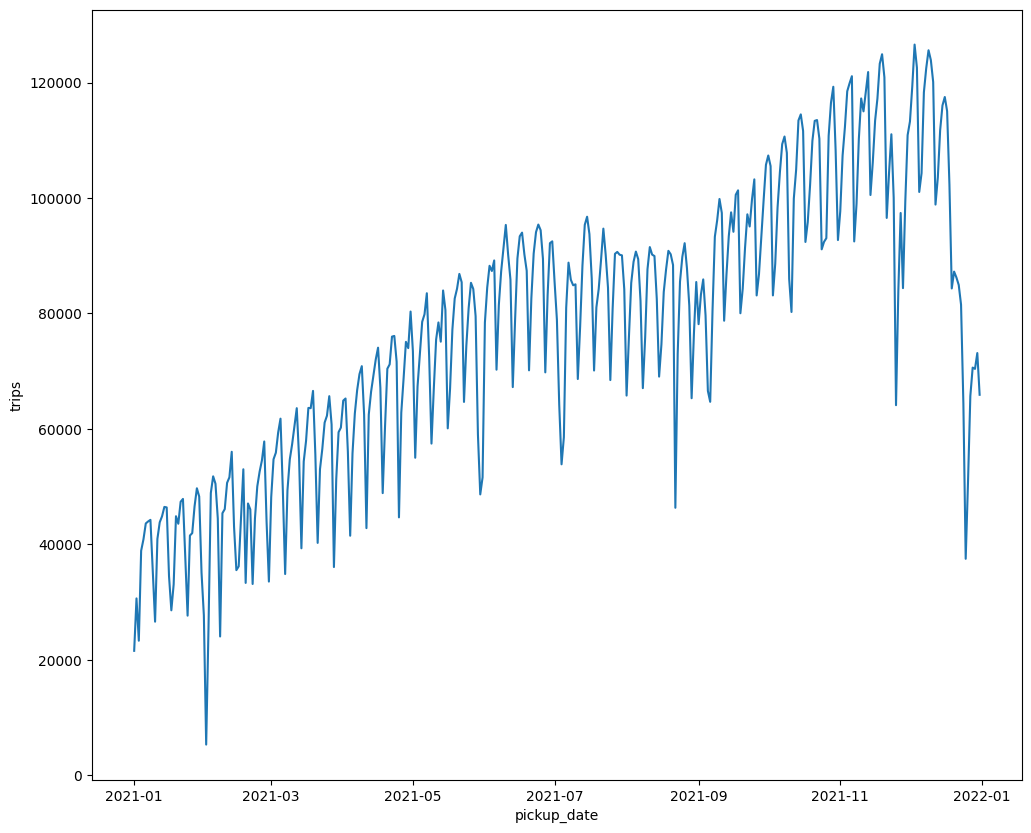

In [64]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(x='pickup_date', y='trips', data=pd_df)

In [69]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') as day_of_week,
    count(*) as trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [83]:
data = pd_df2.groupby('day_of_week').trips.median().to_frame().reset_index()
data["sort_dow"] = data['day_of_week'].replace({'Sunday' : 0,
                                                'Monday' : 1,
                                                'Tuesday' : 2,
                                                'Wednesday' : 3,
                                                'Thursday' : 4,
                                                'Friday' : 5,
                                                'Saturday' : 6})
data.sort_values('sort_dow', inplace=True)

<Axes: xlabel='day_of_week', ylabel='trips'>

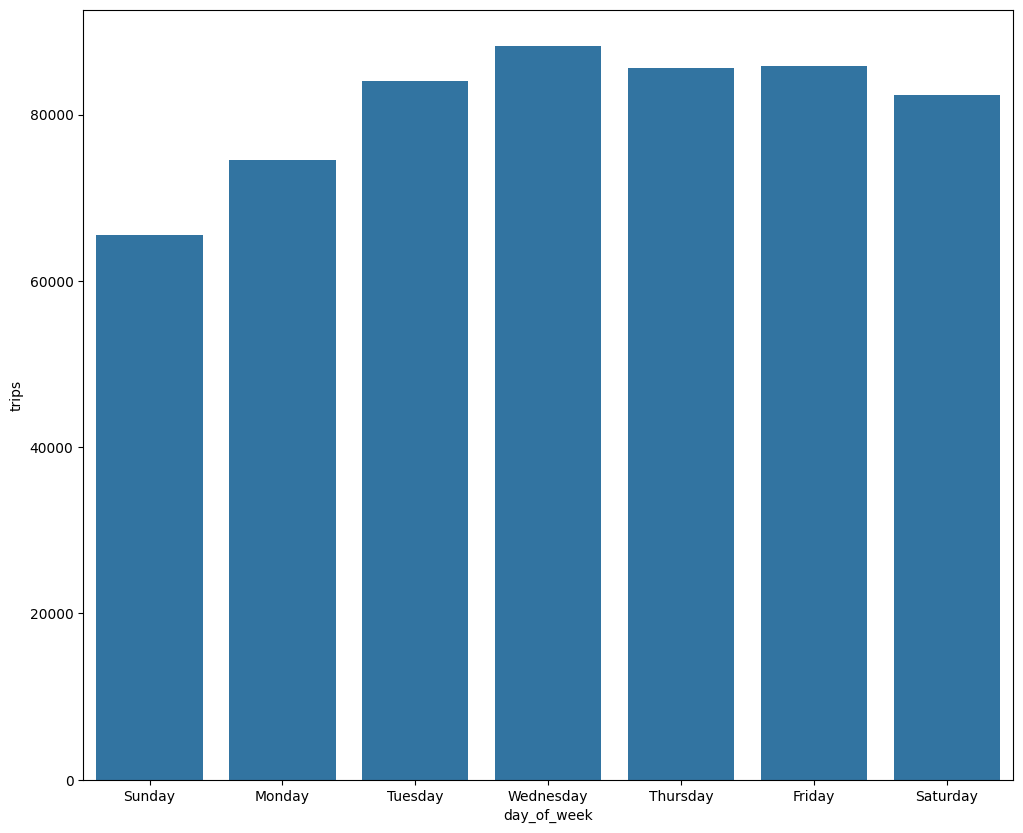

In [89]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x='day_of_week', y='trips', data=data)

In [97]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register('get_weekday', get_weekday)

23/11/10 00:13:57 WARN SimpleFunctionRegistry: The function get_weekday replaced a previously registered function.


<function __main__.get_weekday(data)>